In [40]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score

import tensorflow as tf
from keras.layers import Dense, Input
from collections import Counter
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras import callbacks
from keras import backend as K
from keras.layers import Dropout

import warnings
warnings.filterwarnings("ignore")

import gc

# Checking train data

In [2]:
df_train = pd.read_csv("../data/train.csv")
df_train.head()

,id,var1,var2,var3,var4,var5,var6,var7,var8,var9,...,var60,var61,var62,var63,var64,var65,var66,var67,var68,y
0,1,18,19,2853,29442,1386,2435,35,-999,3,...,0.311441,0.142303,0.056146,0.632694,0.024054,0.253356,0.00603,0.132353,0.139706,1
1,8,4,110,1986,13684,7189,-999,-999,17,3,...,-999.000000,-999.000000,0.070991,0.773966,0.019315,-999.000000,-999.00000,0.147059,0.106618,0
2,30,0,39,1019,10232,678,791,16,-999,3,...,-999.000000,0.200814,0.051046,0.980827,0.018536,-999.000000,-999.00000,0.382353,0.242647,0
3,43,20,39,1751,2689,8235,1042,13,10,1,...,-999.000000,0.352379,0.044301,0.951564,0.023684,0.363370,0.00201,0.147059,0.132353,0
4,46,7,44,2262,29428,6031,304,16,-999,3,...,0.021226,0.226161,0.059125,0.906155,0.020733,-999.000000,-999.00000,0.455882,0.132353,1


In [3]:
df_meta = pd.read_csv("../data/metadata.csv")
df_meta.head()

,Variavel cod,Variavel tipo
0,id,Qualitativo nominal
1,var1,Qualitativo nominal
2,var2,Qualitativo nominal
3,var3,Qualitativo nominal
4,var4,Qualitativo nominal


In [4]:
df_meta["Variavel tipo"].value_counts()

Qualitativo nominal      36
Quantitativo discreto    18
Quantitativo continua    12
Qualitativo ordinal       4
Name: Variavel tipo, dtype: int64

In [5]:
df_train.shape

(14123, 70)

In [6]:
nunique = df_train.drop("y", axis=1).apply(lambda x: len(np.unique(x)), axis=0).sort_values()
nunique

var51        2
var27        2
var49        2
var50        2
var31        2
         ...  
var62    11613
var11    12384
var4     13094
var55    14003
id       14123
Length: 69, dtype: int64

In [7]:
df_train.isna().sum().any()

False

In [8]:
(df_train["id"].value_counts() > 1).any()

False

In [9]:
df_train["id"].min(), df_train["id"].max()

(1, 35306)

In [10]:
# cols = df_meta[df_meta["Variavel tipo"] == "Qualitativo nominal"]["Variavel cod"]
# for col in df_train[df_meta].columns:
#     n = df_train[df_train[col].isin(df_train["id"].values)].shape[0]
#     print(col, n)

# Raw Database (no features)

## Random Forest

In [11]:
y = df_train["y"]
df_train.drop("y", axis=1, inplace=True)

In [12]:
train_preds = y.to_frame("y")
train_preds["preds"] = 0

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(skf.split(df_train, y)):
    x_train, x_test = df_train.loc[train_index], df_train.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = RandomForestClassifier(
        n_estimators=500,
        random_state=0,
        n_jobs=5
    )
    clf.fit(x_train, y_train)
    
    y_pred = clf.predict(x_test)
    train_preds.loc[test_index, "preds"] = y_pred
    
    score = f1_score(y_test, y_pred)    
    print(f"fold {fold+1}, F1: {score}")
    
score = f1_score(train_preds["y"], train_preds["preds"])
print(f"CV F1: {score}")

fold 1, F1: 0.6285119667013527
fold 2, F1: 0.5895196506550219
fold 3, F1: 0.5911542610571736
fold 4, F1: 0.5881081081081081
fold 5, F1: 0.574863387978142
CV F1: 0.594745908699397


## LGB

In [13]:
import lightgbm as lgb

train_preds = y.to_frame("y")
train_preds["preds"] = 0

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(skf.split(df_train, y)):
    x_train, x_test = df_train.loc[train_index], df_train.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = lgb.LGBMClassifier(
        learning_rate=0.01,
        n_estimators=5000,
        random_state=42,
        objective="binary",
        subsample=0.8,
        subsample_freq=10,
        colsample_bytree=0.8,
        max_depth=5
    )
    clf.fit(
        x_train,
        y_train,
        eval_set=[(x_test, y_test)],
        eval_metric="auc",
        early_stopping_rounds=500,
        verbose=1000
    )
    
    y_pred = clf.predict(x_test, num_iteration=clf.best_iteration_)
    train_preds.loc[test_index, "preds"] = y_pred
    
    score = f1_score(y_test, y_pred)    
    print(f"fold {fold+1}, F1: {score}")
    
score = f1_score(train_preds["y"], train_preds["preds"])
print(f"CV F1: {score}")


# CV F1: 0.594745908699397 Raw data RF
# CV F1: 0.6434923201293452 Raw Data LGB: No params
# CV F1: 0.64251012145749 Raw Data LGB: Some params

Training until validation scores don't improve for 500 rounds
[1000]	valid_0's auc: 0.901491	valid_0's binary_logloss: 0.2936
Early stopping, best iteration is:
[659]	valid_0's auc: 0.9016	valid_0's binary_logloss: 0.295855
fold 1, F1: 0.6811023622047244
Training until validation scores don't improve for 500 rounds
[1000]	valid_0's auc: 0.889659	valid_0's binary_logloss: 0.307208
Early stopping, best iteration is:
[625]	valid_0's auc: 0.890913	valid_0's binary_logloss: 0.307425
fold 2, F1: 0.6462167689161554
Training until validation scores don't improve for 500 rounds
[1000]	valid_0's auc: 0.883871	valid_0's binary_logloss: 0.315589
Early stopping, best iteration is:
[1002]	valid_0's auc: 0.883909	valid_0's binary_logloss: 0.315565
fold 3, F1: 0.6292585170340682
Training until validation scores don't improve for 500 rounds
[1000]	valid_0's auc: 0.891767	valid_0's binary_logloss: 0.308735
Early stopping, best iteration is:
[980]	valid_0's auc: 0.892185	valid_0's binary_logloss: 0.30846

## NN

In [49]:
from sklearn.preprocessing import MinMaxScaler

In [52]:
oof_preds = np.zeros(df_train.shape[0])
# sub_preds = np.zeros(df_test_agg.shape[0])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(skf.split(df_train, y)):
    x_train, x_test = df_train.loc[train_index], df_train.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = Sequential()
    clf.add(Dense(2000, input_dim=x_train.shape[1], activation='relu'))
    clf.add(BatchNormalization())
    clf.add(Dropout(0.3))
    
    clf.add(Dense(1000, activation='sigmoid'))
    clf.add(BatchNormalization())
    clf.add(Dropout(0.3))
    
    clf.add(Dense(500, activation='sigmoid'))
    clf.add(BatchNormalization())
    clf.add(Dropout(0.2))
    
    clf.add(Dense(100, activation='sigmoid'))
    clf.add(BatchNormalization())
    clf.add(Dropout(0.2))
    clf.add(Dense(1, activation="sigmoid"))
    
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])
    es = callbacks.EarlyStopping(monitor='val_auc', min_delta=0.001, patience=10,
                                 verbose=1, mode='max', baseline=None, restore_best_weights=True)
    rlr = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                                      patience=3, min_lr=1e-6, mode='max', verbose=1)
    scalar = MinMaxScaler()
    scalar.fit(x_train)
    x_train_scl = scalar.transform(x_train)
    x_test_scl = scalar.transform(x_test)

    clf.fit(x_train_scl, y_train, validation_data=(x_test_scl, y_test), callbacks=[es, rlr], epochs=10, batch_size=32)
#     clf.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)
    
    val_preds = clf.predict_classes(x_test_scl)
    score = f1_score(y_test, val_preds)
    
    print(f"fold:{fold + 1}, f1_score = {score}")
    oof_preds[test_index] = val_preds.ravel()
    
    K.clear_session()
    gc.collect()    
    
print('Full rmse score %.6f' % rmse(y, oof_preds))

Train on 11298 samples, validate on 2825 samples
Epoch 1/10
11298/11298 [==============================] - 18s 2ms/step - loss: 0.4959 - auc: 0.7085 - val_loss: 0.4073 - val_auc: 0.7473
Epoch 2/10
11298/11298 [==============================] - 17s 1ms/step - loss: 0.4195 - auc: 0.7564 - val_loss: 0.3998 - val_auc: 0.7619
Epoch 3/10
11298/11298 [==============================] - 17s 2ms/step - loss: 0.4062 - auc: 0.7654 - val_loss: 0.4250 - val_auc: 0.7718
Epoch 4/10
11298/11298 [==============================] - 17s 2ms/step - loss: 0.3945 - auc: 0.7754 - val_loss: 0.3757 - val_auc: 0.7808
Epoch 5/10
11298/11298 [==============================] - 17s 2ms/step - loss: 0.3924 - auc: 0.7835 - val_loss: 0.3793 - val_auc: 0.7870
Epoch 6/10
11298/11298 [==============================] - 17s 2ms/step - loss: 0.3924 - auc: 0.7887 - val_loss: 0.3933 - val_auc: 0.7905
Epoch 7/10
11298/11298 [==============================] - 17s 2ms/step - loss: 0.3836 - auc: 0.7918 - val_loss: 0.3966 - val_auc:

KeyboardInterrupt: 

# Dummies with qualitative ordinal features

In [54]:
print("shape before dummies: ", df_train.shape)
cols = df_meta[df_meta["Variavel tipo"] == "Qualitativo ordinal"]["Variavel cod"].values[1:]
for col in cols:
    df_dummies = pd.get_dummies(df_train[col])
    df_dummies.columns = [f"{col}_{suffix}" for suffix in df_dummies.columns]
    df_train = df_train.merge(df_dummies, how="left", left_index=True, right_index=True)
print("shape after dummies: ", df_train.shape)

shape before dummies:  (14123, 69)
shape after dummies:  (14123, 144)


## LGB

In [55]:
import lightgbm as lgb

train_preds = y.to_frame("y")
train_preds["preds"] = 0

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(skf.split(df_train, y)):
    x_train, x_test = df_train.loc[train_index], df_train.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = lgb.LGBMClassifier(
        learning_rate=0.01,
        n_estimators=5000,
        random_state=42,
        objective="binary",
        subsample=0.8,
        subsample_freq=10,
        colsample_bytree=0.8,
        max_depth=5
    )
    clf.fit(
        x_train,
        y_train,
        eval_set=[(x_test, y_test)],
        eval_metric="auc",
        early_stopping_rounds=500,
        verbose=1000
    )
    
    y_pred = clf.predict(x_test, num_iteration=clf.best_iteration_)
    train_preds.loc[test_index, "preds"] = y_pred
    
    score = f1_score(y_test, y_pred)    
    print(f"fold {fold+1}, F1: {score}")
    
score = f1_score(train_preds["y"], train_preds["preds"])
print(f"CV F1: {score}")

# CV F1: 0.594745908699397 Raw data RF
# CV F1: 0.6434923201293452 Raw Data LGB: No params
# CV F1: 0.64251012145749 Raw Data LGB: Some params
# CV F1: 0.644040404040404 Dummies on Qual. Ord: some params

Training until validation scores don't improve for 500 rounds
[1000]	valid_0's auc: 0.901652	valid_0's binary_logloss: 0.293686
Early stopping, best iteration is:
[1010]	valid_0's auc: 0.901829	valid_0's binary_logloss: 0.293532
fold 1, F1: 0.6828322017458779
Training until validation scores don't improve for 500 rounds
[1000]	valid_0's auc: 0.888988	valid_0's binary_logloss: 0.307288
Early stopping, best iteration is:
[624]	valid_0's auc: 0.890273	valid_0's binary_logloss: 0.307261
fold 2, F1: 0.6489795918367347
Training until validation scores don't improve for 500 rounds
[1000]	valid_0's auc: 0.884172	valid_0's binary_logloss: 0.315835
[2000]	valid_0's auc: 0.885108	valid_0's binary_logloss: 0.315801
Early stopping, best iteration is:
[1810]	valid_0's auc: 0.885733	valid_0's binary_logloss: 0.315261
fold 3, F1: 0.6379137412236711
Training until validation scores don't improve for 500 rounds
[1000]	valid_0's auc: 0.891745	valid_0's binary_logloss: 0.310146
Early stopping, best iterat

## NN

In [56]:
oof_preds = np.zeros(df_train.shape[0])
# sub_preds = np.zeros(df_test_agg.shape[0])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(skf.split(df_train, y)):
    x_train, x_test = df_train.loc[train_index], df_train.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = Sequential()
    clf.add(Dense(2000, input_dim=x_train.shape[1], activation='relu'))
    clf.add(BatchNormalization())
    clf.add(Dropout(0.3))
    
    clf.add(Dense(1000, activation='sigmoid'))
    clf.add(BatchNormalization())
    clf.add(Dropout(0.3))
    
    clf.add(Dense(500, activation='sigmoid'))
    clf.add(BatchNormalization())
    clf.add(Dropout(0.2))
    
    clf.add(Dense(100, activation='sigmoid'))
    clf.add(BatchNormalization())
    clf.add(Dropout(0.2))
    clf.add(Dense(1, activation="sigmoid"))
    
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])
    es = callbacks.EarlyStopping(monitor='val_auc', min_delta=0.001, patience=10,
                                 verbose=1, mode='max', baseline=None, restore_best_weights=True)
    rlr = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                                      patience=3, min_lr=1e-6, mode='max', verbose=1)
    scalar = MinMaxScaler()
    scalar.fit(x_train)
    x_train_scl = scalar.transform(x_train)
    x_test_scl = scalar.transform(x_test)

    clf.fit(x_train_scl, y_train, validation_data=(x_test_scl, y_test), callbacks=[es, rlr], epochs=10, batch_size=32)
#     clf.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)
    
    val_preds = clf.predict_classes(x_test_scl)
    score = f1_score(y_test, val_preds)
    
    print(f"fold:{fold + 1}, f1_score = {score}")
    oof_preds[test_index] = val_preds.ravel()
    
    K.clear_session()
    gc.collect()    
    
print('Full rmse score %.6f' % rmse(y, oof_preds))

Train on 11298 samples, validate on 2825 samples
Epoch 1/10
11298/11298 [==============================] - 16s 1ms/step - loss: 0.5095 - auc: 0.7040 - val_loss: 0.4155 - val_auc: 0.7298
Epoch 2/10
11298/11298 [==============================] - 16s 1ms/step - loss: 0.4244 - auc: 0.7412 - val_loss: 0.4046 - val_auc: 0.7535
Epoch 3/10
11298/11298 [==============================] - 15s 1ms/step - loss: 0.4068 - auc: 0.7597 - val_loss: 0.3927 - val_auc: 0.7677
Epoch 4/10
11298/11298 [==============================] - 16s 1ms/step - loss: 0.3971 - auc: 0.7719 - val_loss: 0.3908 - val_auc: 0.7772
Epoch 5/10
11298/11298 [==============================] - 18s 2ms/step - loss: 0.3886 - auc: 0.7810 - val_loss: 0.3951 - val_auc: 0.7842
Epoch 6/10
11298/11298 [==============================] - 18s 2ms/step - loss: 0.3855 - auc: 0.7862 - val_loss: 0.3850 - val_auc: 0.7892
Epoch 7/10
11298/11298 [==============================] - 20s 2ms/step - loss: 0.3841 - auc: 0.7910 - val_loss: 0.4100 - val_auc:

KeyboardInterrupt: 

# Dummies with qualitative nominal features

In [57]:
print("shape before dummies: ", df_train.shape)
cols = df_meta[df_meta["Variavel tipo"] == "Qualitativo nominal"]["Variavel cod"].values[1:]
for col in cols:
    df_dummies = pd.get_dummies(df_train[col])
    df_dummies.columns = [f"{col}_{suffix}" for suffix in df_dummies.columns]
    df_train = df_train.merge(df_dummies, how="left", left_index=True, right_index=True)
print("shape after dummies: ", df_train.shape)

shape before dummies:  (14123, 144)
shape after dummies:  (14123, 46953)


## LGB

In [58]:
import lightgbm as lgb

train_preds = y.to_frame("y")
train_preds["preds"] = 0

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(skf.split(df_train, y)):
    x_train, x_test = df_train.loc[train_index], df_train.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = lgb.LGBMClassifier(
        learning_rate=0.01,
        n_estimators=5000,
        random_state=42,
        objective="binary",
        subsample=0.8,
        subsample_freq=10,
        colsample_bytree=0.8,
        max_depth=5
    )
    clf.fit(
        x_train,
        y_train,
        eval_set=[(x_test, y_test)],
        eval_metric="auc",
        early_stopping_rounds=500,
        verbose=1000
    )
    
    y_pred = clf.predict(x_test, num_iteration=clf.best_iteration_)
    train_preds.loc[test_index, "preds"] = y_pred
    
    score = f1_score(y_test, y_pred)    
    print(f"fold {fold+1}, F1: {score}")
    
score = f1_score(train_preds["y"], train_preds["preds"])
print(f"CV F1: {score}")

# CV F1: 0.594745908699397 Raw data RF
# CV F1: 0.6434923201293452 Raw Data LGB: No params
# CV F1: 0.64251012145749 Raw Data LGB: Some params
# CV F1: 0.644040404040404 Dummies on Qual. Ord: some params
# CV F1: 0.6462159434914228 Dummies on Qual.Ord and Qual.Nom.: some params

Training until validation scores don't improve for 500 rounds
[1000]	valid_0's auc: 0.901045	valid_0's binary_logloss: 0.294575
Early stopping, best iteration is:
[736]	valid_0's auc: 0.90195	valid_0's binary_logloss: 0.295417
fold 1, F1: 0.6828793774319066
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[475]	valid_0's auc: 0.88947	valid_0's binary_logloss: 0.309359
fold 2, F1: 0.6475409836065573
Training until validation scores don't improve for 500 rounds
[1000]	valid_0's auc: 0.88057	valid_0's binary_logloss: 0.318624
Early stopping, best iteration is:
[1385]	valid_0's auc: 0.881764	valid_0's binary_logloss: 0.317878
fold 3, F1: 0.634
Training until validation scores don't improve for 500 rounds
[1000]	valid_0's auc: 0.892076	valid_0's binary_logloss: 0.308138
Early stopping, best iteration is:
[1340]	valid_0's auc: 0.892893	valid_0's binary_logloss: 0.307204
fold 4, F1: 0.6495901639344263
Training until validation scores don't impro

In [59]:
df_train.head()

,id,var1,var2,var3,var4,var5,var6,var7,var8,var9,...,var41_0,var41_1,var41_2,var41_3,var41_4,var41_5,var41_6,var41_7,var41_8,var41_9
0,1,18,19,2853,29442,1386,2435,35,-999,3,...,0,0,0,1,0,0,0,0,0,0
1,8,4,110,1986,13684,7189,-999,-999,17,3,...,0,0,0,1,0,0,0,0,0,0
2,30,0,39,1019,10232,678,791,16,-999,3,...,0,0,0,1,0,0,0,0,0,0
3,43,20,39,1751,2689,8235,1042,13,10,1,...,0,0,0,1,0,0,0,0,0,0
4,46,7,44,2262,29428,6031,304,16,-999,3,...,0,0,0,1,0,0,0,0,0,0


In [71]:
cols = df_meta["Variavel cod"].values

In [68]:
na_sum = df_train[cols].apply(lambda x: sum(x == -999), axis=1)
na_sum.head()

0    1
1    2
2    1
3    0
4    1
dtype: int64

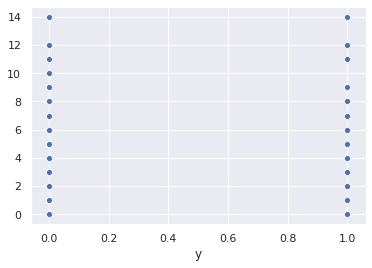

In [72]:
sns.scatterplot(y, na_sum)

In [73]:
na_sum.to_frame("n_na")

,n_na
0,1
1,2
2,1
3,0
4,1
...,...
14118,2
14119,11
14120,0
14121,0
